# Tallinn and Helsinky. How similar or dissimilar they are?

[World Urbanization Prospects 2018: Highlights](https://population.un.org/wup/Publications/Files/WUP2018-Highlights.pdf)

["Tallinn Base Map: Tallinn’s subdistrict boundaries"](http://www.tallinn.ee/est/g6497s92804)  
[Tallinn population stats](https://www.tallinn.ee/Yearbooks-and-Statistics)

https://ogre.adc4gis.com/


Source: [District Map of the City of Helsinki](https://hri.fi/data/en_GB/dataset/helsingin-kaupunginosat).  The maintainer of the dataset is Helsingin kaupunkiympäristön toimiala / Kaupunkimittauspalvelut. The dataset has been downloaded from [Helsinki Region Infoshare](https://hri.fi/) service on 22.11.2019 under the license [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/).

https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json


Source: [Statistical Yearbook of Helsinki](https://hri.fi/data/en_GB/dataset/helsingin-tilastollinen-vuosikirja).  The maintainer of the dataset is Helsingin kaupunginkanslia / Kaupunkitutkimus ja -tilastot. The dataset has been downloaded from Helsinki Region Infoshare service on 02.12.2019 under the license Creative Commons Attribution 4.0.  

http://www.hel.fi/hel2/tietokeskus/data/helsinki/tieke/helsingin_kaupungin_tilastollinen_vuosikirja_2018/Helsingin_tilastollinen_vuosikirja_2018.zip  


https://www.hel.fi/hel2/tietokeskus/helsinki_alueittain_2005/203Haaga.pdf

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
 

### Install packages and load libraries

In [16]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.show_dimensions',True)
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle json

In [17]:
#!conda install -c conda-forge geopy --yes 
#!conda install -c conda-forge pyproj --yes 

In [18]:
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
# transform geo coordinates
from pyproj import Proj, transform

In [19]:
#!conda config --set ssl_verify false 
#!conda install -c conda-forge folium=0.5.0 --yes

In [20]:
import folium # plotting library
print(folium.__version__)

0.5.0


## Tallinn

Let's load geo data and create map with district boundaries and pandas dataframe with district names and coordiantes.

To load geo data I use ["Tallinn Base Map: Tallinn’s subdistrict boundaries"](http://www.tallinn.ee/est/g6497s92804) resource to download shape files for boundaries and then with [ogre web site](https://ogre.adc4gis.com/) covert it to geojson format.
> NB! Because of shape file contains coordiantes in Estonian Coordinate System (EPSG:3301) use appropriate options to covert coordinates in World Geodetic System (EPSG:4326)
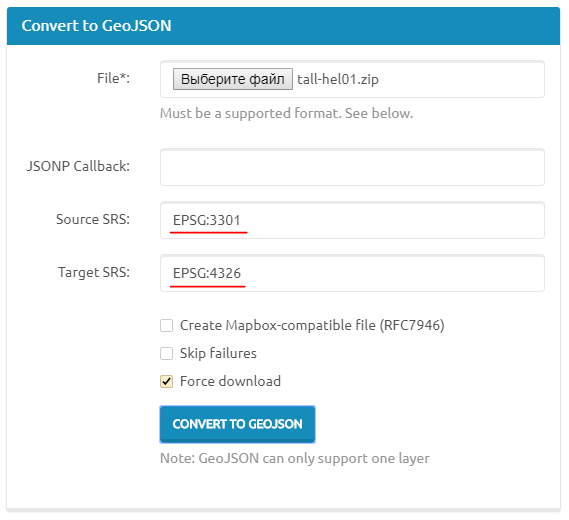
  
As a result I get json file renamed to *tallinn_geo_converted.json*.  
To create dataframe I walk through this file getting district name and using geopy library to define coordinates. First, let's create function for getting coordinates by address:

In [21]:
def coordinates(geolocator, district_name, address_pattern):
    address = address_pattern.format(district_name)
    location = geolocator.geocode(address, timeout=20)
    latitude = location.latitude
    longitude = location.longitude
        
    return location.latitude, location.longitude

In [22]:
# define Tallinn coordiantes
address = 'Tallinn, Etonia'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address, timeout=10)
tallinn_latitude = location.latitude
tallinn_longitude = location.longitude
print(tallinn_latitude, tallinn_longitude)

59.4372155 24.7453688


Done. It's time for dataframe:

In [24]:
with open('tallinn_geo_converted.json', encoding='utf-8') as json_data:
    tallinn_data = json.load(json_data)

tallinn_districts = []
features = tallinn_data['features']
for feature in features:
    properties = feature['properties']
    latitude, longitude  = coordinates(geolocator, 
                                       district_name='{},{}'.format(properties['asumi_nimi'], properties['linnaosa_n']),
                                       address_pattern='{}, Tallinn, Estonia')
    tallinn_districts.append([properties['linna_nimi'],properties['linnaosa_n'],properties['asumi_nimi'], latitude, longitude])
tallinn_districts[0:5]

[['Tallinna linn', 'Kesklinna linnaosa', 'Raua', 59.4357193, 24.7723688],
 ['Tallinna linn', 'Pirita linnaosa', 'Iru', 59.4591879, 24.8984111],
 ['Tallinna linn', 'Lasnamäe linnaosa', 'Seli', 59.4442151, 24.893329],
 ['Tallinna linn', 'Lasnamäe linnaosa', 'Sõjamäe', 59.4245821, 24.8434934],
 ['Tallinna linn', 'Nõmme linnaosa', 'Kivimäe', 59.3770852, 24.6566655]]

In [25]:
df_tallinn = pd.DataFrame(tallinn_districts, columns=['City','Borough','Neighborhood', 'Latitude', 'Longitude'])
df_tallinn.head(10)

City                  Borough Neighborhood   Latitude  Longitude
0  Tallinna linn  Kesklinna linnaosa       Raua         59.435719  24.772369
1  Tallinna linn  Pirita linnaosa          Iru          59.459188  24.898411
2  Tallinna linn  Lasnamäe linnaosa        Seli         59.444215  24.893329
3  Tallinna linn  Lasnamäe linnaosa        Sõjamäe      59.424582  24.843493
4  Tallinna linn  Nõmme linnaosa           Kivimäe      59.377085  24.656665
5  Tallinna linn  Lasnamäe linnaosa        Kuristiku    59.451492  24.866185
6  Tallinna linn  Põhja-Tallinna linnaosa  Pelguranna   59.448281  24.691792
7  Tallinna linn  Nõmme linnaosa           Hiiu         59.379609  24.675097
8  Tallinna linn  Põhja-Tallinna linnaosa  Merimetsa    59.434183  24.695458
9  Tallinna linn  Kesklinna linnaosa       Kompassi     59.435810  24.760920

[10 rows x 5 columns]

In [26]:
df_tallinn.describe(include='all')

City             Borough Neighborhood   Latitude  Longitude
count   84             84                  84           84.000000  84.000000
unique  1              8                   84          NaN        NaN       
top     Tallinna linn  Kesklinna linnaosa  Merivälja   NaN        NaN       
freq    84             21                  1           NaN        NaN       
mean    NaN            NaN                 NaN          59.430940  24.748024
std     NaN            NaN                 NaN          0.032064   0.084777 
min     NaN            NaN                 NaN          59.356078  24.572694
25%     NaN            NaN                 NaN          59.412823  24.691225
50%     NaN            NaN                 NaN          59.433929  24.746235
75%     NaN            NaN                 NaN          59.446210  24.816982
max     NaN            NaN                 NaN          59.581319  24.910270

[11 rows x 5 columns]

In [27]:
import os

if os.path.exists('tallinn_heighborhoods.csv'):
    print('tallinn_heighborhoods.csv exists')
else:
    df_tallinn.to_csv('tallinn_heighborhoods.csv', encoding='utf-8')

tallinn_heighborhoods.csv exists


In [39]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=12) # generate map centred around the Tallinn
#tallinn_markers = folium.map.FeatureGroup()
# add markers to map
def style_function(feature):
    return {
        'color' : 'orange',
        'weight' : 2,        
        'fillOpacity': 0.2,
#        'weight': 0,
        'line_opacity': 0.2,
        'fillColor': '#fafa00' 
    }

folium.GeoJson('tallinn_geo_converted.json', style_function=style_function).add_to(tallinn_map)
for lat, lng, label in zip(df_tallinn['Latitude'], df_tallinn['Longitude'], df_tallinn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#fff00a',
        fill_opacity=0.2,
        parse_html=False).add_to(tallinn_map)  
tallinn_map

Let's correct some coordinates:

- Pirita - 59.468293, 24.834434
- Mähe - 59.482542, 24.852122
- Tondiraba - 59.442126, 24.859120
- Pae - 59.435165, 24.822060
- Uuslinn - 59.437080, 24.803290
- Juhkentali - 59.425090, 24.769411
- Veerenni - 59.424482, 24.749281
- Kitseküla - 59.414870, 24.739392
- Tondi - 59.408026, 24.724908
- Lilleküla - 59.419546, 24.712606
- Siili - 59.406715, 24.706119
- Sääse - 59.409706, 24.695449
- Pelguranna - 59.447834, 24.692225
- Mustjõe - 59.428602, 24.680109
- Veskimetsa - 59.420996, 24.660690
- Liiva - 59.382957, 24.731037
- Laagri - 59.355412, 24.619176
- Vana-Mustamäe - 59.390358, 24.645816
- Astangu - 59.402235, 24.627247
- Kopli - 59.459025, 24.673429
- Nõmme - 59.379267, 24.694357
- Väo - 59.435219, 24.897147
- Haabersti - 59.427789, 24.643465
- Pikaliiva - 59.429962, 24.612633

I did it manualy in file. Moreover i added data about size and population using wikipedia.

In [458]:
df_tallinn = pd.read_csv('tallinn_heighborhoods.csv', encoding='utf-8')
#df_tallinn["Population"] = (100. * df_tallinn["Population"] / df_tallinn["Population"].sum())
df_tallinn.head(10)

Id           City                  Borough Neighborhood  Population  Size  \
0  0   Tallinna linn  Kesklinna linnaosa       Raua         5959        0.31   
1  1   Tallinna linn  Pirita linnaosa          Iru          34          0.43   
2  2   Tallinna linn  Lasnamäe linnaosa        Seli         12533       0.95   
3  3   Tallinna linn  Lasnamäe linnaosa        Sõjamäe      120         7.47   
4  4   Tallinna linn  Nõmme linnaosa           Kivimäe      4856        2.22   
5  5   Tallinna linn  Lasnamäe linnaosa        Kuristiku    11065       0.84   
6  6   Tallinna linn  Põhja-Tallinna linnaosa  Pelguranna   15007       1.00   
7  7   Tallinna linn  Nõmme linnaosa           Hiiu         3967        2.63   
8  8   Tallinna linn  Põhja-Tallinna linnaosa  Merimetsa    4           1.34   
9  9   Tallinna linn  Kesklinna linnaosa       Kompassi     2001        0.16   

    Latitude  Longitude  
0  59.436456  24.768514  
1  59.461624  24.904461  
2  59.444215  24.893329  
3  59.424582  24.843493  
4  59.378019  24.655907  
5  59.451492  24.866185  
6  59.447834  24.692225  
7  59.383453  24.671893  
8  59.434183  24.695458  
9  59.435810  24.760920  

[10 rows x 8 columns]

In [41]:
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=11) # generate map centred around the Tallinn

folium.GeoJson('tallinn_geo_converted.json', style_function=style_function).add_to(tallinn_map)
for lat, lng, label in zip(df_tallinn['Latitude'], df_tallinn['Longitude'], df_tallinn['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#fff00a',
        fill_opacity=0.7,
        parse_html=False).add_to(tallinn_map)  
tallinn_map

## Helsinki

Let's make similar geodata preparation for Helsinki. Lucky me, we are able to get geo data in geojson format for city of Helsinki using [Helsinki Region Infoshare](https://hri.fi/) service. Just submit query [District Map of the City of Helsinki]( https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json)

In [42]:
import urllib3

urllib3.disable_warnings()

session = requests.Session()
session.verify = False  # SSL verification will be turned OFF, requests will give you an InsecureRequestWarning

# create the API request URL
url = 'https://kartta.hel.fi/ws/geoserver/avoindata/wfs?version=1.1.0&request=GetFeature&typeName=avoindata:Kaupunginosajako&outputformat=json'
# make the GET request
results = session.get(url).json() #["response"]['groups'][0]['items']
results

{'crs': {'properties': {'name': 'urn:ogc:def:crs:EPSG::3879'}, 'type': 'name'},
 'features': [{'geometry': {'coordinates': [[[25492719.1749788,
       6673875.36173711],
      [25493462.4188057, 6673254.25743011],
      [25494394.4998769, 6674325.42935366],
      [25494755.1112754, 6674739.85199555],
      [25494764.1390835, 6674733.95520776],
      [25494810.7195735, 6674713.9245289],
      [25494885.5238174, 6674688.29867894],
      [25494905.4748441, 6674679.77538749],
      [25494931.1226707, 6674715.96874126],
      [25494933.6189781, 6674719.49160006],
      [25494955.6747853, 6674768.94252281],
      [25494969.9170829, 6674797.60227495],
      [25494975.4507747, 6674808.21030174],
      [25494994.504058, 6674842.55900518],
      [25495010.1555411, 6674868.80799026],
      [25495027.3856417, 6674895.83486853],
      [25495044.4458555, 6674920.8750735],
      [25495054.5521003, 6674934.89696398],
      [25495065.6345284, 6674950.07856765],
      [25495091.8888605, 6674983.9534184]

As we see geo coordinates introduced in local coordinate system (espg:3879). We have translate it to World Geodetic System (EPSG:4326).  
So, let's create functions:

In [43]:
def covert_coordinates(json_data, output_file, in_epsg='epsg:3879', out_epsg='epsg:4326'):
    inProj = Proj(init=in_epsg) # epsg:3879 - finland
    outProj = Proj(init=out_epsg)# epsg:4326 WGS 84 -- WGS84 - World Geodetic System 1984, used in GPS
    features = json_data['features']
    features[0]
    for feature in features:
        geometry = feature['geometry']
        print(geometry['type'], np.shape(geometry['coordinates']))
        Polygons = []
        if geometry['type'] == 'MultiPolygon' :
            Polygons = geometry['coordinates']
        else:
            Polygons.append(geometry['coordinates'])

        for polygon in Polygons:
            points = polygon[0]
            for point in points:
                point[0],point[1] = transform(inProj,outProj,point[0],point[1])

            
    with open(output_file, "w", encoding='utf-8') as write_file:
        json.dump(json_data, write_file, ensure_ascii=False)

def covert_coordinates_in_file(input_file, output_file, in_epsg='epsg:3879', out_epsg='epsg:4326'):
    with open(input_file, encoding='utf-8') as json_data:
        epsg_data = json.load(json_data)

    convert_coordinates(espg_data, output_file, in_epsg, out_epsg)


In [44]:
covert_coordinates(results, 'helsinki_geo_converted.json', in_epsg='epsg:3879', out_epsg='epsg:4326')

Polygon (1, 99, 2)
Polygon (1, 123, 2)
Polygon (1, 122, 2)
Polygon (1, 1492, 2)
Polygon (1, 138, 2)
Polygon (1, 83, 2)
Polygon (1, 322, 2)
Polygon (1, 10, 2)
Polygon (1, 126, 2)
Polygon (1, 287, 2)
Polygon (1, 218, 2)
Polygon (1, 443, 2)
Polygon (1, 593, 2)
Polygon (1, 219, 2)
Polygon (1, 491, 2)
Polygon (1, 28, 2)
Polygon (1, 219, 2)
Polygon (1, 819, 2)
Polygon (1, 343, 2)
Polygon (1, 76, 2)
Polygon (1, 87, 2)
Polygon (1, 16, 2)
Polygon (1, 140, 2)
Polygon (1, 19, 2)
Polygon (1, 359, 2)
Polygon (1, 39, 2)
Polygon (1, 173, 2)
Polygon (1, 281, 2)
Polygon (1, 103, 2)
Polygon (1, 35, 2)
Polygon (1, 223, 2)
Polygon (1, 97, 2)
Polygon (1, 147, 2)
Polygon (1, 21, 2)
Polygon (1, 121, 2)
Polygon (1, 65, 2)
Polygon (1, 58, 2)
Polygon (1, 35, 2)
Polygon (1, 958, 2)
Polygon (1, 29, 2)
Polygon (1, 85, 2)
Polygon (1, 39, 2)
Polygon (1, 20, 2)
Polygon (1, 312, 2)
Polygon (1, 114, 2)
Polygon (1, 364, 2)
Polygon (1, 51, 2)
Polygon (1, 214, 2)
Polygon (1, 99, 2)
Polygon (1, 280, 2)
Polygon (1, 634, 2)


In [45]:
with open('helsinki_geo_converted.json', encoding='utf-8') as json_data:
    helsinki_data = json.load(json_data)

helsinki_districts = []
features = helsinki_data['features']
for feature in features:
    properties = feature['properties']
    #print(properties['yhtdatanomistaja'], properties['tunnus'], properties['nimi_fi'])

    latitude, longitude  = coordinates(geolocator, 
                                       district_name=properties['nimi_fi'],
                                       address_pattern='{}, Helsinki, Finland')
    helsinki_districts.append([properties['yhtdatanomistaja'],properties['tunnus'],properties['nimi_fi'], latitude, longitude])

helsinki_districts[0:5]

[['Helsinki/Kami', '15', 'MEILAHTI', 60.1913479, 24.9026643],
 ['Helsinki/Kami', '43', 'HERTTONIEMI', 60.1955246, 25.0290632],
 ['Helsinki/Kami', '10', 'SÖRNÄINEN', 60.1838848, 24.9644087],
 ['Helsinki/Kami', '55', 'ÖSTERSUNDOM', 60.25960365, 25.187008478540385],
 ['Helsinki/Kami', '21', 'HERMANNI', 60.1966243, 24.9709346]]

In [46]:
df_helsinki = pd.DataFrame(helsinki_districts, columns=['City','Borough','Neighborhood', 'Latitude', 'Longitude'])
df_helsinki.head(10)

City   Borough Neighborhood   Latitude  Longitude
0  Helsinki/Kami  15        MEILAHTI     60.191348  24.902664
1  Helsinki/Kami  43        HERTTONIEMI  60.195525  25.029063
2  Helsinki/Kami  10        SÖRNÄINEN    60.183885  24.964409
3  Helsinki/Kami  55        ÖSTERSUNDOM  60.259604  25.187008
4  Helsinki/Kami  21        HERMANNI     60.196624  24.970935
5  Helsinki/Kami  30        MUNKKINIEMI  60.199094  24.874358
6  Helsinki/Kami  22        VALLILA      60.196167  24.956710
7  Helsinki/Kami  Aluemeri  ALUEMERI     59.999293  25.020177
8  Helsinki/Kami  07        ULLANLINNA   60.158715  24.949404
9  Helsinki/Kami  58        KARHUSAARI   60.251043  25.223406

[10 rows x 5 columns]

In [47]:
import os
if os.path.exists("helsinki_heighborhoods.csv"):
    print('helsinki_heighborhoods.csv exists')
else:
    df_helsinki.to_csv('helsinki_heighborhoods.csv', encoding='utf-8')

helsinki_heighborhoods.csv exists


In [48]:
address = 'Helsinki, Finland'

location = geolocator.geocode(address)
helsinki_latitude = location.latitude
helsinki_longitude = location.longitude
print(helsinki_latitude, helsinki_longitude)

60.1674098 24.9425769


In [49]:
helsinki_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11) # generate map centred around the Helsinki
folium.GeoJson('helsinki_geo_converted.json', style_function=style_function).add_to(helsinki_map)
for lat, lng, label in zip(df_helsinki['Latitude'], df_helsinki['Longitude'], df_helsinki['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#fff00a',
        fill_opacity=0.7,
        parse_html=False).add_to(helsinki_map)  
helsinki_map

Correct some coordinates:

- KARHUSAARI - 60.251099, 25.218480  
- ULKOSAARET - 60.101523, 25.050689
  
I did it manualy in file. Moreover i added data about size and population using wikipedia.

In [459]:
df_helsinki = pd.read_csv('helsinki_heighborhoods.csv', encoding='utf-8', index_col='Id')
#df_helsinki["Population"] = (100. * df_helsinki["Population"] / df_helsinki["Population"].sum())
df_helsinki.head(10)

City  Borough Neighborhood  Population  Size   Latitude  \
Id                                                                     
0   Helsinki/Kami  15       MEILAHTI     5111        2.12  60.191348   
1   Helsinki/Kami  43       HERTTONIEMI  28566       6.06  60.195525   
2   Helsinki/Kami  10       SÖRNÄINEN    9809        1.66  60.183885   
3   Helsinki/Kami  55       ÖSTERSUNDOM  523         7.50  60.259604   
4   Helsinki/Kami  21       HERMANNI     6073        1.05  60.196624   
5   Helsinki/Kami  30       MUNKKINIEMI  17982       4.74  60.199094   
6   Helsinki/Kami  22       VALLILA      10140       1.30  60.196167   
8   Helsinki/Kami  7        ULLANLINNA   10706       0.75  60.158715   
9   Helsinki/Kami  58       KARHUSAARI   418         1.58  60.251099   
10  Helsinki/Kami  16       RUSKEASUO    10304       2.12  60.204803   

    Longitude  
Id             
0   24.902664  
1   25.029063  
2   24.964409  
3   25.187008  
4   24.970935  
5   24.874358  
6   24.956710  
8   24.949404  
9   25.218480  
10  24.905621  

[10 rows x 7 columns]

In [51]:
helsinki_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11) # generate map centred around the Helsinki

folium.GeoJson('helsinki_geo_converted.json', style_function=style_function).add_to(helsinki_map)
for lat, lng, label in zip(df_helsinki['Latitude'], df_helsinki['Longitude'], df_helsinki['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#fff00a',
        fill_opacity=0.7,
        parse_html=False).add_to(helsinki_map)  
helsinki_map

## Clustering

Next, I'm going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [464]:
CLIENT_ID = 'WEVQCJHZEB4W2QOPCUXISUGPEB14ZDED5WSGP1TATCXL4PNR' # your Foursquare ID
CLIENT_SECRET = '2OZIDWDQUFLTEY2GUECESB11HUBKWAB1CTPVMKAHRWGCP1YK' # your Foursquare Secret
VERSION = '20191118' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Let's combine city dataframes together:

In [461]:
df_neighborhoods = pd.concat([df_tallinn, df_helsinki], ignore_index=False)
df_neighborhoods.drop('Id', axis=1, inplace=True)
df_neighborhoods.head()

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


Borough           City   Latitude  Longitude Neighborhood  \
0  Kesklinna linnaosa  Tallinna linn  59.436456  24.768514  Raua          
1  Pirita linnaosa     Tallinna linn  59.461624  24.904461  Iru           
2  Lasnamäe linnaosa   Tallinna linn  59.444215  24.893329  Seli          
3  Lasnamäe linnaosa   Tallinna linn  59.424582  24.843493  Sõjamäe       
4  Nõmme linnaosa      Tallinna linn  59.378019  24.655907  Kivimäe       

   Population  Size  
0  5959        0.31  
1  34          0.43  
2  12533       0.95  
3  120         7.47  
4  4856        2.22  

[5 rows x 7 columns]

In [462]:
df_neighborhoods.describe(include='all')

Borough           City    Latitude   Longitude  \
count   143                 143            143.000000  143.000000   
unique  67                  2             NaN         NaN           
top     Kesklinna linnaosa  Tallinna linn NaN         NaN           
freq    21                  84            NaN         NaN           
mean    NaN                 NaN            59.749376   24.848195    
std     NaN                 NaN            0.382600    0.147642     
min     NaN                 NaN            59.355412   24.570101    
25%     NaN                 NaN            59.430046   24.730604    
50%     NaN                 NaN            59.453371   24.846065    
75%     NaN                 NaN            60.187558   24.953759    
max     NaN                 NaN            60.283019   25.218480    

       Neighborhood    Population        Size  
count   143          143.000000    143.000000  
unique  143         NaN           NaN          
top     VARTIOSAARI NaN           NaN          
freq    1           NaN           NaN          
mean    NaN          7224.853147   2.587692    
std     NaN          8939.662732   2.883941    
min     NaN          0.000000      0.130000    
25%     NaN          1067.000000   0.820000    
50%     NaN          3967.000000   1.580000    
75%     NaN          10047.500000  3.205000    
max     NaN          51417.000000  16.550000   

[11 rows x 7 columns]

In [370]:
df_neighborhoods.to_csv('all_heighborhoods.csv', encoding='utf-8')

Let's create a function to generate top 100 venues within a radius of 500 meters for every neighborhoods:

In [466]:
from time import sleep

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    sleep(2)
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        #print(url)    
        # make the GET request
        results = session.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using function above I create new dataframe:

In [ ]:
#from requests.packages.urllib3.exceptions import InsecureRequestWarning
# disable ssl warnings
#requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

df_venues = getNearbyVenues(names=df_neighborhoods['Neighborhood'],
                                   latitudes=df_neighborhoods['Latitude'],
                                   longitudes=df_neighborhoods['Longitude'],
                                   radius=radius
                                  )

Raua
Iru
Seli
Sõjamäe
Kivimäe
Kuristiku
Pelguranna
Hiiu
Merimetsa
Kompassi
Mähe
Luite
Sääse
Väo
Tõnismäe
Haabersti
Uuslinn
Kloostrimetsa
Nõmme
Pelgulinn
Kose
Mustakivi
Veerenni
Vismeistri
Sitsi
Laagna
Tondiraba
Maarjamäe
Lepiku
Keldrimäe
Pikaliiva
Laagri
Sibulaküla
Südalinn
Pae
Tatari


In [62]:
df_venues.to_csv('all_venues.csv', encoding='utf-8')
print(df_venues.shape)
df_venues.head()

(2767, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Raua         59.436456              24.768514                
1  Raua         59.436456              24.768514                
2  Raua         59.436456              24.768514                
3  Raua         59.436456              24.768514                
4  Raua         59.436456              24.768514                

               Venue  Venue Latitude  Venue Longitude Venue Category  
0  Hilton             59.433892       24.768677        Hotel          
1  SaltRestoran       59.435093       24.773610        Restaurant     
2  Bogi Hookah Place  59.438529       24.770771        Lounge         
3  Faehlmanni kohvik  59.434709       24.773160        Café           
4  Radio              59.434918       24.771919        Restaurant     

[5 rows x 7 columns]

Let's check how many venues were returned for each neighborhood:

In [63]:
df_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                          
ALPPIHARJU     28                     28                      28      
Aegna          1                      1                       1       
Astangu        1                      1                       1       
EIRA           33                     33                      33      
ETU-TÖÖLÖ      38                     38                      38      
...            ..                     ..                      ..      
Väike-Õismäe   8                      8                       8       
Õismäe         3                      3                       3       
ÖSTERSUNDOM    2                      2                       2       
Ülemiste       10                     10                      10      
Ülemistejärve  8                      8                       8       

               Venue Latitude  Venue Longitude  Venue Category  
Neighborhood                                                    
ALPPIHARJU     28              28               28              
Aegna          1               1                1               
Astangu        1               1                1               
EIRA           33              33               33              
ETU-TÖÖLÖ      38              38               38              
...            ..              ..               ..              
Väike-Õismäe   8               8                8               
Õismäe         3               3                3               
ÖSTERSUNDOM    2               2                2               
Ülemiste       10              10               10              
Ülemistejärve  8               8                8               

[141 rows x 6 columns]

Let's find out how many unique categories can be curated from all the returned venues:

In [64]:
print('There are {} uniques categories.'.format(len(df_venues['Venue Category'].unique())))

There are 332 uniques categories.


Using one-hot encoding method I transform dataframe df_venues into dataframe of categoies of venues:

In [285]:
# one hot encoding
df_venue_categories = pd.get_dummies(df_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
df_venue_categories['Neighborhood'] = df_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [df_venue_categories.columns[-1]] + list(df_venue_categories.columns[:-1])
df_venue_categories = df_venue_categories[fixed_columns]

print(df_venue_categories.shape)
df_venue_categories.head()

(2767, 333)


Neighborhood  Accessories Store  African Restaurant  American Restaurant  \
0  Raua         0                  0                   0                     
1  Raua         0                  0                   0                     
2  Raua         0                  0                   0                     
3  Raua         0                  0                   0                     
4  Raua         0                  0                   0                     

   Antique Shop  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  \
0  0             0         0       0                       0             
1  0             0         0       0                       0             
2  0             0         0       0                       0             
3  0             0         0       0                       0             
4  0             0         0       0                       0             

   Art Museum  ...  Warehouse Store  Waterfront  Whisky Bar  Wine Bar  \
0  0           ...  0                0           0           0          
1  0           ...  0                0           0           0          
2  0           ...  0                0           0           0          
3  0           ...  0                0           0           0          
4  0           ...  0                0           0           0          

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0  0          0            0              0            0    0            
1  0          0            0              0            0    0            
2  0          0            0              0            0    0            
3  0          0            0              0            0    0            
4  0          0            0              0            0    0            

[5 rows x 333 columns]

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category:

In [385]:
df_neighborhood_categories = df_venue_categories.groupby('Neighborhood').mean().reset_index()
df_neighborhood_categories

Neighborhood  Accessories Store  African Restaurant  \
0    ALPPIHARJU     0.0                0.0                  
1    Aegna          0.0                0.0                  
2    Astangu        0.0                0.0                  
3    EIRA           0.0                0.0                  
4    ETU-TÖÖLÖ      0.0                0.0                  
..         ...      ...                ...                  
136  Väike-Õismäe   0.0                0.0                  
137  Õismäe         0.0                0.0                  
138  ÖSTERSUNDOM    0.0                0.0                  
139  Ülemiste       0.0                0.0                  
140  Ülemistejärve  0.0                0.0                  

     American Restaurant  Antique Shop  Aquarium  Arcade  \
0    0.0                  0.0           0.035714  0.0      
1    0.0                  0.0           0.000000  0.0      
2    0.0                  0.0           0.000000  0.0      
3    0.0                  0.0           0.000000  0.0      
4    0.0                  0.0           0.000000  0.0      
..   ...                  ...                ...  ...      
136  0.0                  0.0           0.000000  0.0      
137  0.0                  0.0           0.000000  0.0      
138  0.0                  0.0           0.000000  0.0      
139  0.0                  0.0           0.000000  0.0      
140  0.0                  0.0           0.000000  0.0      

     Argentinian Restaurant  Art Gallery  Art Museum  ...  Warehouse Store  \
0    0.0                     0.0          0.0         ...  0.0               
1    0.0                     0.0          0.0         ...  0.0               
2    0.0                     0.0          0.0         ...  0.0               
3    0.0                     0.0          0.0         ...  0.0               
4    0.0                     0.0          0.0         ...  0.0               
..   ...                     ...          ...         ...  ...               
136  0.0                     0.0          0.0         ...  0.0               
137  0.0                     0.0          0.0         ...  0.0               
138  0.0                     0.0          0.0         ...  0.0               
139  0.0                     0.0          0.0         ...  0.0               
140  0.0                     0.0          0.0         ...  0.0               

     Waterfront  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0    0.000000    0.0         0.000000  0.0        0.0          0.0             
1    0.000000    0.0         0.000000  0.0        0.0          0.0             
2    0.000000    0.0         0.000000  0.0        0.0          0.0             
3    0.030303    0.0         0.030303  0.0        0.0          0.0             
4    0.000000    0.0         0.000000  0.0        0.0          0.0             
..        ...    ...              ...  ...        ...          ...             
136  0.000000    0.0         0.000000  0.0        0.0          0.0             
137  0.000000    0.0         0.000000  0.0        0.0          0.0             
138  0.000000    0.0         0.000000  0.0        0.0          0.0             
139  0.000000    0.0         0.000000  0.0        0.0          0.0             
140  0.000000    0.0         0.000000  0.0        0.0          0.0             

     Yoga Studio  Zoo  Zoo Exhibit  
0    0.000000     0.0  0.0          
1    0.000000     0.0  0.0          
2    0.000000     0.0  0.0          
3    0.000000     0.0  0.0          
4    0.026316     0.0  0.0          
..        ...     ...  ...          
136  0.000000     0.0  0.0          
137  0.000000     0.0  0.0          
138  0.000000     0.0  0.0          
139  0.000000     0.0  0.0          
140  0.000000     0.0  0.0          

[141 rows x 333 columns]

In [432]:
from sklearn.preprocessing import StandardScaler

#summary = df_venue_categories.select_dtypes(pd.np.number).sum()
#unique_categories = summary[summary<2].index.to_list()
#df_venue_categories.drop(unique_categories, axis=1, inplace=True)
#unique_categories
df_neighborhood_categories = df_venue_categories.groupby('Neighborhood').sum().reset_index()

df_neighborhood_categories = df_neighborhood_categories.merge(df_neighborhoods[['Population','Neighborhood']], how='left', on='Neighborhood')

df_neighborhood_categories = df_neighborhood_categories[df_neighborhood_categories['Population'] != 0]

df_categories_without_neighborhood = df_neighborhood_categories.drop('Neighborhood', axis=1)
df_categories_without_neighborhood = (1000 * df_categories_without_neighborhood.div(df_categories_without_neighborhood["Population"], axis=0))
#df_categories_without_neighborhood

#scaled_categories = StandardScaler().fit_transform(df_categories_without_neighborhood.values)
#df_scaled_categories = pd.DataFrame(scaled_categories, index=df_categories_without_neighborhood.index, columns=df_categories_without_neighborhood.columns)
df_scaled_categories = df_categories_without_neighborhood.drop('Population', axis=1)
df_scaled_categories

Accessories Store  African Restaurant  American Restaurant  Antique Shop  \
0    0.0                0.0                 0.0                  0.0            
1    0.0                0.0                 0.0                  0.0            
2    0.0                0.0                 0.0                  0.0            
3    0.0                0.0                 0.0                  0.0            
4    0.0                0.0                 0.0                  0.0            
..   ...                ...                 ...                  ...            
136  0.0                0.0                 0.0                  0.0            
137  0.0                0.0                 0.0                  0.0            
138  0.0                0.0                 0.0                  0.0            
139  0.0                0.0                 0.0                  0.0            
140  0.0                0.0                 0.0                  0.0            

     Aquarium  Arcade  Argentinian Restaurant  Art Gallery  Art Museum  \
0    0.082122  0.0     0.0                     0.0          0.0          
1    0.000000  0.0     0.0                     0.0          0.0          
2    0.000000  0.0     0.0                     0.0          0.0          
3    0.000000  0.0     0.0                     0.0          0.0          
4    0.000000  0.0     0.0                     0.0          0.0          
..        ...  ...     ...                     ...          ...          
136  0.000000  0.0     0.0                     0.0          0.0          
137  0.000000  0.0     0.0                     0.0          0.0          
138  0.000000  0.0     0.0                     0.0          0.0          
139  0.000000  0.0     0.0                     0.0          0.0          
140  0.000000  0.0     0.0                     0.0          0.0          

     Arts & Crafts Store  ...  Warehouse Store  Waterfront  Whisky Bar  \
0    0.0                  ...  0.0              0.000000    0.0          
1    0.0                  ...  0.0              0.000000    0.0          
2    0.0                  ...  0.0              0.000000    0.0          
3    0.0                  ...  0.0              0.882613    0.0          
4    0.0                  ...  0.0              0.000000    0.0          
..   ...                  ...  ...                   ...    ...          
136  0.0                  ...  0.0              0.000000    0.0          
137  0.0                  ...  0.0              0.000000    0.0          
138  0.0                  ...  0.0              0.000000    0.0          
139  0.0                  ...  0.0              0.000000    0.0          
140  0.0                  ...  0.0              0.000000    0.0          

     Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  \
0    0.000000  0.0        0.0          0.0            0.000000     0.0   
1    0.000000  0.0        0.0          0.0            0.000000     0.0   
2    0.000000  0.0        0.0          0.0            0.000000     0.0   
3    0.882613  0.0        0.0          0.0            0.000000     0.0   
4    0.000000  0.0        0.0          0.0            0.066702     0.0   
..        ...  ...        ...          ...                 ...     ...   
136  0.000000  0.0        0.0          0.0            0.000000     0.0   
137  0.000000  0.0        0.0          0.0            0.000000     0.0   
138  0.000000  0.0        0.0          0.0            0.000000     0.0   
139  0.000000  0.0        0.0          0.0            0.000000     0.0   
140  0.000000  0.0        0.0          0.0            0.000000     0.0   

     Zoo Exhibit  
0    0.0          
1    0.0          
2    0.0          
3    0.0          
4    0.0          
..   ...          
136  0.0          
137  0.0          
138  0.0          
139  0.0          
140  0.0          

[140 rows x 332 columns]

At this point we are ready to split our neigborhoods on several clusters.  

### Clustering heighborhoods

Run k-means to cluster the neighborhood into 5 clusters.

In [433]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(df_scaled_categories)
    inertia[n-2] = kmeans.inertia_
inertia

array([1.73667679e+06, 8.54780150e+05, 3.58437196e+05, 1.72438391e+05,
       8.87982005e+04, 4.61425030e+04, 2.67683515e+04, 1.60807533e+04,
       1.06807752e+04, 6.80436101e+03, 3.38336320e+03, 2.69489857e+03,
       2.08851558e+03, 1.62527667e+03])

#### Plot  model inertia  for Different number of clusters 

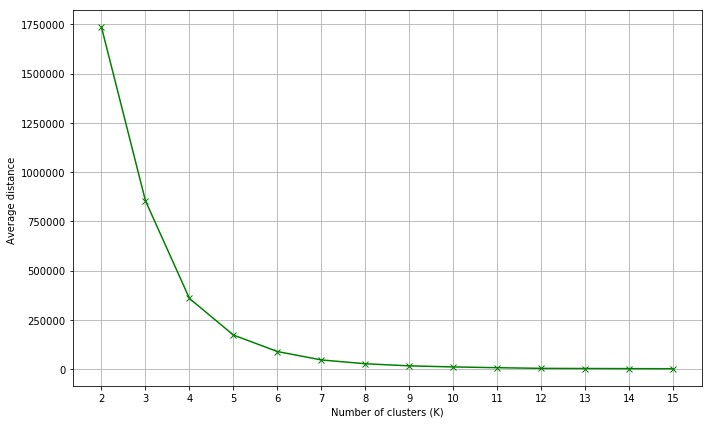

In [434]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

As we see there is no obvious elbow point in this plot. Let's apply silhouette analisys to define appropriate value for clusters amount[x].  

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For n_clusters = 2 The average silhouette_score is : 0.9602764077391961
For n_clusters = 3 The average silhouette_score is : 0.9519930849794704
For n_clusters = 4 The average silhouette_score is : 0.9467268396331459
For n_clusters = 5 The average silhouette_score is : 0.9331441172403534
For n_clusters = 6 The average silhouette_score is : 0.9206769746141709
For n_clusters = 7 The average silhouette_score is : 0.9095789002258883
For n_clusters = 8 The average silhouette_score is : 0.8931205944532321
For n_clusters = 9 The average silhouette_score is : 0.8789133119889627
For n_clusters = 10 The average silhouette_score is : 0.8601894184591257
For n_clusters = 11 The average silhouette_score is : 0.8524371042479485
For n_clusters = 12 The average silhouette_score is : 0.852167438609511
For n_clusters = 13 The average silhouette_score is : 0.7411635934313179
For n_clusters = 14 The average silhouette_score is : 0.7476130394246608
For n_clusters = 15 The average silhouette_score is : 0.7519

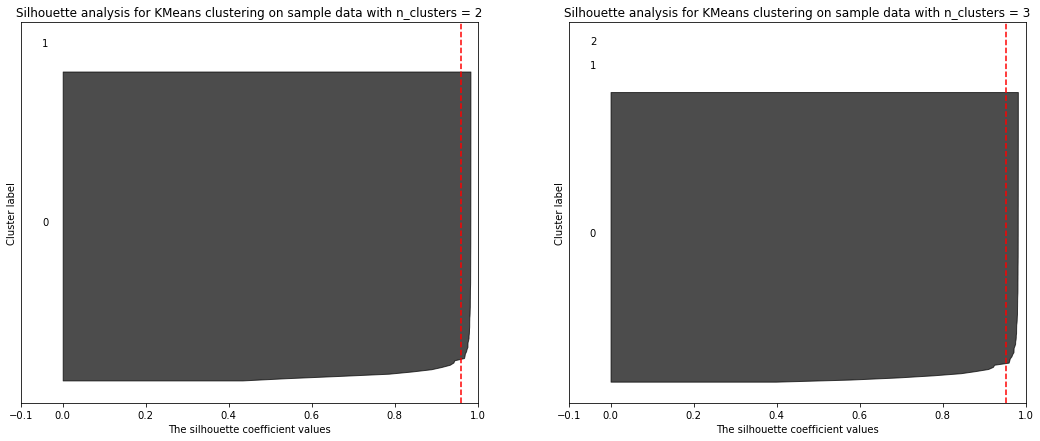

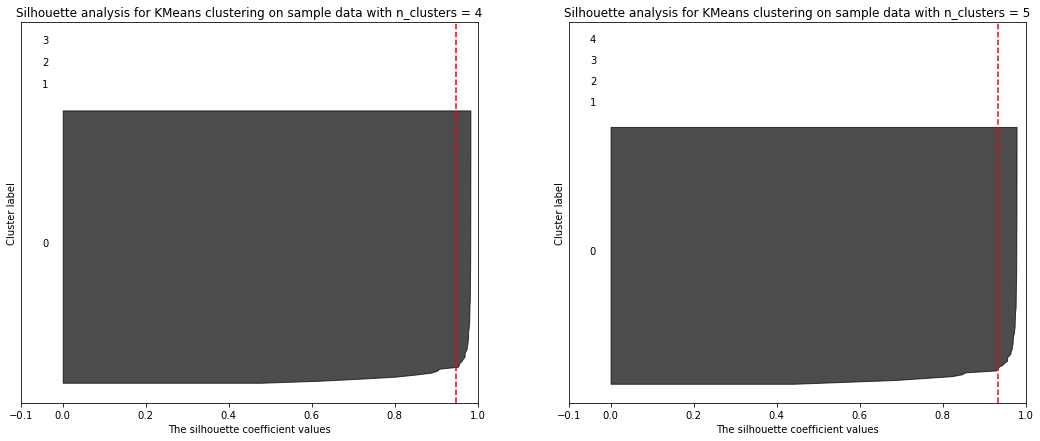

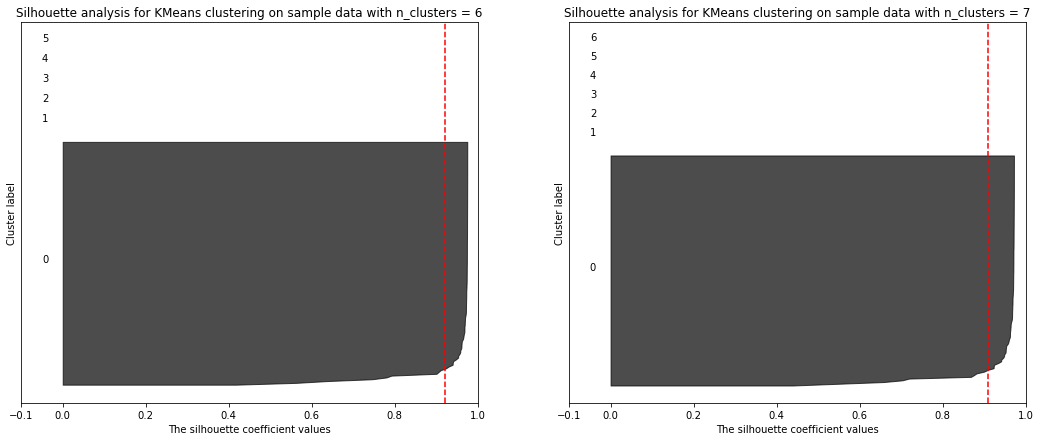

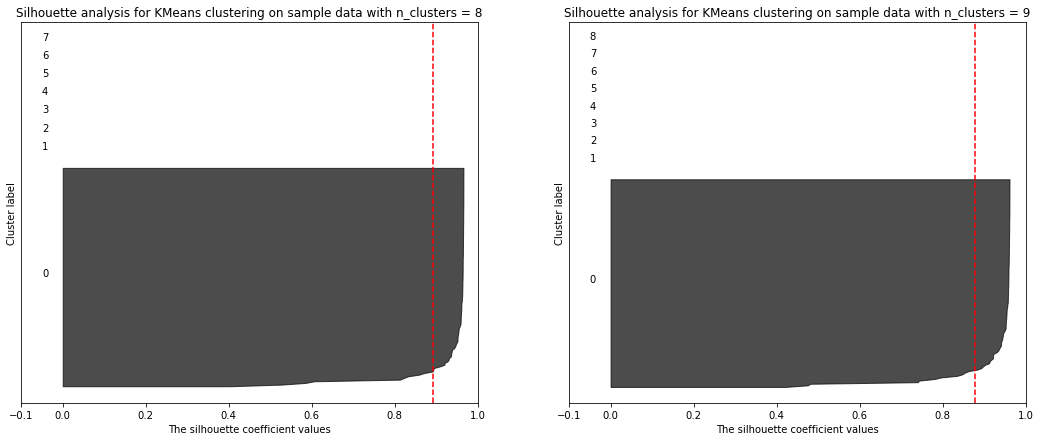

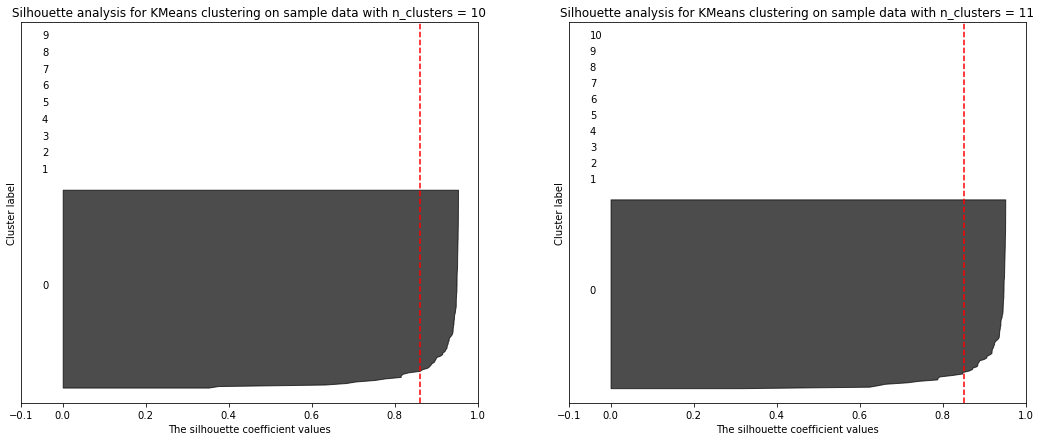

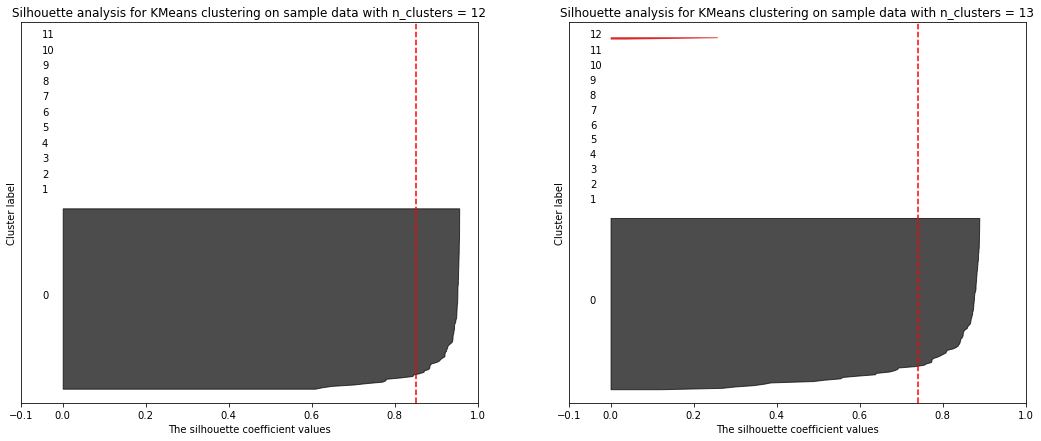

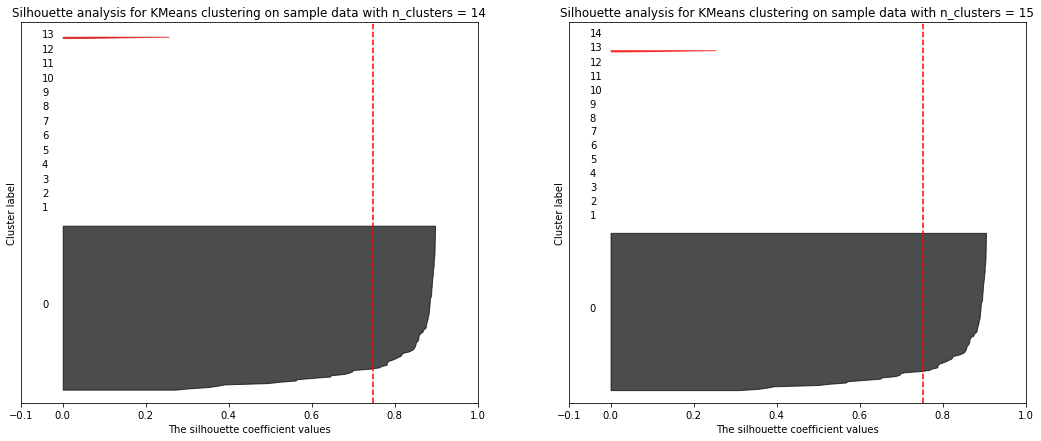

In [435]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

for n_clusters in range(2,Ks):
    # Create a subplot with 1 row and 2 columns
    if n_clusters %2 == 0 :
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax = ax1
    else :
        ax = ax2
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(df_scaled_categories) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=SEED)
    cluster_labels = clusterer.fit_predict(df_scaled_categories)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_scaled_categories, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_scaled_categories, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette analysis for KMeans clustering on sample data with n_clusters = {}".format(n_clusters), loc='center')
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.show()

In [436]:
# set number of clusters
kclusters = 5

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(df_scaled_categories)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Done! Add cluster labels to neighborhood categories dataframe:

In [443]:
df_neighborhood_categories.insert(0, 'Cluster Label', kmeans.labels_)
#df_neighborhood_categories = df_neighborhood_categories.drop('Population', axis=1)
df_neighborhood_categories.head()

ValueError: cannot insert Cluster Label, already exists

### Combine data together

Let's add clustering data to neghborhood dataframe for analysis purposes.  To do this I create new column with top 10 venues categories for each neghborhood and then add it to neghborhood dataframe together with cluster labels.
  
First, create function to sort the venues categories in descending order and combine list of them:

In [444]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    # sort values for only present categories
    row_categories_sorted = row_categories.where(row_categories > 0).dropna().sort_values(ascending=False)
    try:
        result = row_categories_sorted.index.values[0:num_top_venues]
    except:
        result = row_categories_sorted.index.values
    return ','.join(result.tolist())

Let's create new column called 'Top 10' in clustering dataframe:

In [445]:
df_neighborhood_categories['Top 10'] = df_neighborhood_categories.apply(lambda x: return_most_common_venues(x,10), axis=1)

TypeError: ("'>' not supported between instances of 'str' and 'int'", 'occurred at index 0')

In [446]:
df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']].head(10)

Cluster Label Neighborhood  \
0  0              ALPPIHARJU    
1  0              Aegna         
2  0              Astangu       
3  0              EIRA          
4  0              ETU-TÖÖLÖ     
5  0              HAAGA         
6  0              HERMANNI      
7  0              HERTTONIEMI   
8  0              Haabersti     
9  0              Hiiu          

                                                                                                                                                 Top 10  
0  Theme Park Ride / Attraction,Park,Greek Restaurant,Tram Station,Bar,Beer Bar,Beer Garden,Blini House,Bowling Alley,Café                               
1  Campground                                                                                                                                            
2  Bus Stop                                                                                                                                              
3  Scandinavian Restaurant,Park,Bakery,Ice Cream Shop,Boat or Ferry,Café,Playground,Coffee Shop,French Restaurant,Italian Restaurant                     
4  Scandinavian Restaurant,Sushi Restaurant,Bakery,Restaurant,Pub,Plaza,Park,Café,Coffee Shop,Gym                                                        
5  Bus Stop,Sushi Restaurant,Supermarket,Soccer Field,Shoe Repair,Recreation Center,Platform,Pizza Place,Garden,Café                                     
6  Park,Yoga Studio,Sporting Goods Shop,Sauna / Steam Room,Recycling Facility,Pizza Place,Gym,Flea Market,Bar                                            
7  Bus Stop,Gym / Fitness Center,Supermarket,Sandwich Place,Grocery Store,Buffet,Café,Chinese Restaurant,Convenience Store,Discount Store                
8  Clothing Store,Gym / Fitness Center,Tennis Court,Supermarket,Hotel,Hockey Arena,Hardware Store,Furniture / Home Store,Convenience Store,Concert Hall  
9  Trail,Pool Hall                                                                                                                                       

[10 rows x 3 columns]

At this point we ready to create new dataframe for all data we have - neighborhoods, geographic coordinates, venue categories and clustering labels. Let's merge it together:

In [447]:
df_tallinn_clustered = df_tallinn.merge(df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']], how='left', on='Neighborhood')
df_tallinn_clustered.head()

Id           City             Borough Neighborhood  Population  Size  \
0  0   Tallinna linn  Kesklinna linnaosa  Raua         5959        0.31   
1  1   Tallinna linn  Pirita linnaosa     Iru          34          0.43   
2  2   Tallinna linn  Lasnamäe linnaosa   Seli         12533       0.95   
3  3   Tallinna linn  Lasnamäe linnaosa   Sõjamäe      120         7.47   
4  4   Tallinna linn  Nõmme linnaosa      Kivimäe      4856        2.22   

    Latitude  Longitude  Cluster Label  \
0  59.436456  24.768514  0.0             
1  59.461624  24.904461  0.0             
2  59.444215  24.893329  0.0             
3  59.424582  24.843493  0.0             
4  59.378019  24.655907  0.0             

                                                                                                                      Top 10  
0  Restaurant,Café,Wings Joint,Italian Restaurant,Bridal Shop,Burger Joint,Casino,Health & Beauty Service,Hotel,Liquor Store  
1  Shopping Mall,Hookah Bar,Historic Site,Grocery Store                                                                       
2  Bus Station,Wine Shop,Supermarket,Fast Food Restaurant,Department Store,Bus Stop                                           
3  Furniture / Home Store,Supermarket,Food,Café,Bus Stop,Bus Line                                                             
4  Playground,Train Station,Theme Park,Nightclub,Music Venue,Dog Run,Bus Station                                              

[5 rows x 10 columns]

In [448]:
df_helsinki_clustered = df_helsinki.merge(df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']], how='left', on='Neighborhood')
df_helsinki_clustered.head()

City  Borough Neighborhood  Population  Size   Latitude  \
0  Helsinki/Kami  15       MEILAHTI     5111        2.12  60.191348   
1  Helsinki/Kami  43       HERTTONIEMI  28566       6.06  60.195525   
2  Helsinki/Kami  10       SÖRNÄINEN    9809        1.66  60.183885   
3  Helsinki/Kami  55       ÖSTERSUNDOM  523         7.50  60.259604   
4  Helsinki/Kami  21       HERMANNI     6073        1.05  60.196624   

   Longitude  Cluster Label  \
0  24.902664  0.0             
1  25.029063  0.0             
2  24.964409  0.0             
3  25.187008  0.0             
4  24.970935  0.0             

                                                                                                                                            Top 10  
0  Tram Station,Scandinavian Restaurant,Gym / Fitness Center,Bus Stop,Bar,Vietnamese Restaurant,Tennis Court,Supermarket,Sandwich Place,Playground  
1  Bus Stop,Gym / Fitness Center,Supermarket,Sandwich Place,Grocery Store,Buffet,Café,Chinese Restaurant,Convenience Store,Discount Store           
2  Recreation Center,Pizza Place,Park,Burger Joint,Nightclub,Thai Restaurant,Event Space,Vietnamese Restaurant,Cocktail Bar,Bar                     
3  Stables,Hobby Shop                                                                                                                               
4  Park,Yoga Studio,Sporting Goods Shop,Sauna / Steam Room,Recycling Facility,Pizza Place,Gym,Flea Market,Bar                                       

[5 rows x 9 columns]

In [449]:
df_helsinki_clustered.to_csv('helsinki_geo_clustered.csv', encoding='utf-8')
df_tallinn_clustered.to_csv('tallinn_geo_clustered.csv', encoding='utf-8')

#### Finally, let's visualize the resulting clusters.  

In [450]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import math

# nine clusters plus one for unclustered
tiles_colors = ['purple', 'yellow', 'orange', 'red', 'blue', 'darkblue', 'lightgreen', 'green', 'darkgrey', 'white']
#tiles_colors = ['purple', 'yellow', 'orange', 'red', 'blue', 'darkblue', 'green', 'white']

In [451]:
# Convert cluster label to int type and fill unclustered heighborhoods by value of kclusters
df_neighborhoods_clustered = df_neighborhoods.merge(df_neighborhood_categories[['Cluster Label', 'Neighborhood', 'Top 10']], how='left', on='Neighborhood')
df_neighborhoods_clustered['Cluster Label'] = df_neighborhoods_clustered['Cluster Label'].fillna(kclusters).astype(int)
df_neighborhoods_clustered.head()

Borough           City   Latitude  Longitude Neighborhood  \
0  Kesklinna linnaosa  Tallinna linn  59.436456  24.768514  Raua          
1  Pirita linnaosa     Tallinna linn  59.461624  24.904461  Iru           
2  Lasnamäe linnaosa   Tallinna linn  59.444215  24.893329  Seli          
3  Lasnamäe linnaosa   Tallinna linn  59.424582  24.843493  Sõjamäe       
4  Nõmme linnaosa      Tallinna linn  59.378019  24.655907  Kivimäe       

   Population  Size  Cluster Label  \
0  5959        0.31  0               
1  34          0.43  0               
2  12533       0.95  0               
3  120         7.47  0               
4  4856        2.22  0               

                                                                                                                      Top 10  
0  Restaurant,Café,Wings Joint,Italian Restaurant,Bridal Shop,Burger Joint,Casino,Health & Beauty Service,Hotel,Liquor Store  
1  Shopping Mall,Hookah Bar,Historic Site,Grocery Store                                                                       
2  Bus Station,Wine Shop,Supermarket,Fast Food Restaurant,Department Store,Bus Stop                                           
3  Furniture / Home Store,Supermarket,Food,Café,Bus Stop,Bus Line                                                             
4  Playground,Train Station,Theme Park,Nightclub,Music Venue,Dog Run,Bus Station                                              

[5 rows x 9 columns]

In [452]:
clusters_stats = df_neighborhoods_clustered[['Cluster Label', 'City','Neighborhood']].groupby(['Cluster Label','City'])['City'].count().unstack('City',0)#.stack()#.reset_index()
clusters_stats = clusters_stats.drop(kclusters) # remove unclustered 
clusters_stats

City           Helsinki/Kami  Tallinna linn
Cluster Label                              
0              57             79           
1              0              1            
2              1              0            
3              0              1            
4              0              1            

[5 rows x 2 columns]

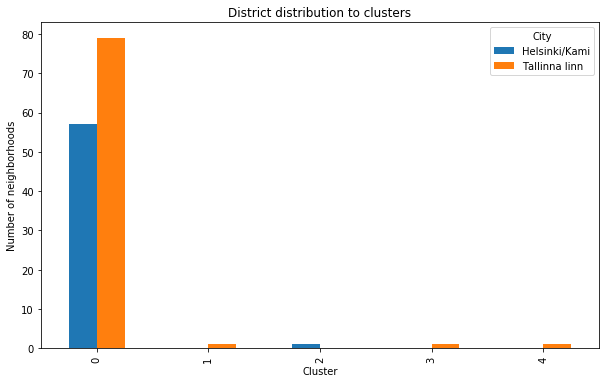

In [453]:
clusters_stats.plot(kind='bar', figsize=(10, 6), stacked=False)
plt.xlabel('Cluster') # add to x-label to the plot
plt.ylabel('Number of neighborhoods') # add y-label to the plot
plt.title('District distribution to clusters') # add title to the plot

plt.show()

In [454]:
tallinn_color_dict = df_tallinn_clustered.set_index('Neighborhood')['Cluster Label'].fillna(kclusters)
#tallinn_color_dict['Raua']
tiles_colors[kclusters]

'darkblue'

In [455]:
from folium.features import DivIcon
tallinn_map = folium.Map(location=[tallinn_latitude, tallinn_longitude], zoom_start=12) # generate map centred around the Tallinn
fg= folium.FeatureGroup(name='My Map')
folium.GeoJson(open('tallinn_geo_converted.json',encoding = 'utf-8').read(), 
    style_function=lambda feature: {
        'fillColor': tiles_colors[int(tallinn_color_dict[feature['properties']['asumi_nimi']])],
        'color': 'black',
        'weight': 1,
        'nan_fill_color': 'purple',
        'nan_fill_opacity': 0.3,
        'dashArray': '5, 5',
        'fillOpacity': 0.4,
    }
).add_to(tallinn_map)
for lat, lon, poi in zip(df_tallinn_clustered['Latitude'], df_tallinn_clustered['Longitude'], df_tallinn_clustered['Neighborhood']):

    label = folium.Popup(str(poi), parse_html=True)
    folium.map.Marker(
        [lat, lon],
        popup=poi,
        icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0), html='<div style="font-size: 8pt">%s</div>' % int(tallinn_color_dict[poi]),)
    ).add_to(tallinn_map)
tallinn_map.save('tallinn.html')
tallinn_map

In [456]:
helsinki_color_dict = df_helsinki_clustered.set_index('Neighborhood')['Cluster Label'].fillna(kclusters)
helsinki_color_dict['SÖRNÄINEN']

0.0

In [457]:
from folium.features import DivIcon

helsinki_map = folium.Map(location=[helsinki_latitude, helsinki_longitude], zoom_start=11) # generate map centred around the Tallinn
folium.GeoJson(open('helsinki_geo_converted.json',encoding = 'utf-8').read(), 
    style_function=lambda feature: {
        'fillColor': tiles_colors[int(helsinki_color_dict[feature['properties']['nimi_fi']])],
        'color': 'black',
        'weight': 1,
        'nan_fill_color': 'purple',
        'nan_fill_opacity': 0.4,
        'dashArray': '5, 5',
        'fillOpacity': 0.4,
    }
).add_to(helsinki_map)

for lat, lon, poi in zip(df_helsinki_clustered['Latitude'], df_helsinki_clustered['Longitude'], df_helsinki_clustered['Neighborhood']):

    label = folium.Popup(str(poi), parse_html=True)
    folium.map.Marker(
        [lat, lon],
        popup=poi,
        icon=DivIcon(icon_size=(150,36), icon_anchor=(0,0), html='<div style="font-size: 8pt">%s</div>' % int(helsinki_color_dict[poi]),)
    ).add_to(helsinki_map)

helsinki_map.save('helsinki.html')
helsinki_map

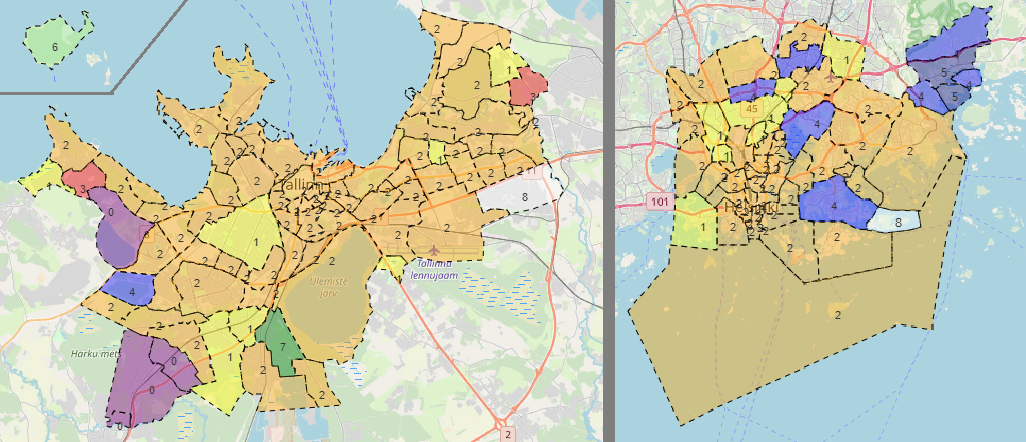

In [332]:
df_cluster_categories = df_venue_categories.groupby('Neighborhood').sum().reset_index()
df_cluster_categories.head(10)

Neighborhood  Accessories Store  African Restaurant  American Restaurant  \
0  ALPPIHARJU   0                  0                   0                     
1  Aegna        0                  0                   0                     
2  Astangu      0                  0                   0                     
3  EIRA         0                  0                   0                     
4  ETU-TÖÖLÖ    0                  0                   0                     
5  HAAGA        0                  0                   0                     
6  HERMANNI     0                  0                   0                     
7  HERTTONIEMI  0                  0                   0                     
8  Haabersti    0                  0                   0                     
9  Hiiu         0                  0                   0                     

   Antique Shop  Aquarium  Arcade  Argentinian Restaurant  Art Gallery  \
0  0             1         0       0                       0             
1  0             0         0       0                       0             
2  0             0         0       0                       0             
3  0             0         0       0                       0             
4  0             0         0       0                       0             
5  0             0         0       0                       0             
6  0             0         0       0                       0             
7  0             0         0       0                       0             
8  0             0         0       0                       0             
9  0             0         0       0                       0             

   Art Museum  ...  Warehouse Store  Waterfront  Whisky Bar  Wine Bar  \
0  0           ...  0                0           0           0          
1  0           ...  0                0           0           0          
2  0           ...  0                0           0           0          
3  0           ...  0                1           0           1          
4  0           ...  0                0           0           0          
5  0           ...  0                0           0           0          
6  0           ...  0                0           0           0          
7  0           ...  0                0           0           0          
8  0           ...  0                0           0           0          
9  0           ...  0                0           0           0          

   Wine Shop  Wings Joint  Women's Store  Yoga Studio  Zoo  Zoo Exhibit  
0  0          0            0              0            0    0            
1  0          0            0              0            0    0            
2  0          0            0              0            0    0            
3  0          0            0              0            0    0            
4  0          0            0              1            0    0            
5  0          0            0              0            0    0            
6  0          0            0              1            0    0            
7  0          0            0              1            0    0            
8  0          0            0              0            0    0            
9  0          0            0              0            0    0            

[10 rows x 333 columns]

In [333]:
df_cluster_categories.insert(0, 'Cluster Label', kmeans.labels_)
df_cluster_categories.head()

Cluster Label Neighborhood  Accessories Store  African Restaurant  \
0  1              ALPPIHARJU   0                  0                    
1  5              Aegna        0                  0                    
2  7              Astangu      0                  0                    
3  1              EIRA         0                  0                    
4  1              ETU-TÖÖLÖ    0                  0                    

   American Restaurant  Antique Shop  Aquarium  Arcade  \
0  0                    0             1         0        
1  0                    0             0         0        
2  0                    0             0         0        
3  0                    0             0         0        
4  0                    0             0         0        

   Argentinian Restaurant  Art Gallery  ...  Warehouse Store  Waterfront  \
0  0                       0            ...  0                0            
1  0                       0            ...  0                0            
2  0                       0            ...  0                0            
3  0                       0            ...  0                1            
4  0                       0            ...  0                0            

   Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
0  0           0         0          0            0              0             
1  0           0         0          0            0              0             
2  0           0         0          0            0              0             
3  0           1         0          0            0              0             
4  0           0         0          0            0              1             

   Zoo  Zoo Exhibit  
0  0    0            
1  0    0            
2  0    0            
3  0    0            
4  0    0            

[5 rows x 334 columns]

In [335]:
categories = df_cluster_categories.groupby(['Cluster Label']).sum().T
categories

Cluster Label        0   1  2  3  4  5  6  7  8
Accessories Store    0  1   0  0  0  0  0  0  0
African Restaurant   0  1   0  0  0  0  0  0  0
American Restaurant  0  6   0  0  0  0  0  0  0
Antique Shop         0  1   0  0  0  0  0  0  0
Aquarium             0  1   0  0  0  0  0  0  0
...                 .. ..  .. .. .. .. .. .. ..
Wings Joint          0  1   0  0  0  0  0  0  0
Women's Store        0  2   0  0  0  0  0  0  0
Yoga Studio          0  12  0  0  0  0  0  0  0
Zoo                  0  2   0  0  0  0  0  0  0
Zoo Exhibit          0  3   0  0  0  0  0  0  0

[332 rows x 9 columns]

In [276]:
categories[3].sort_values(ascending=False)[0:10]

Bus Station             3
Zoo Exhibit             0
Event Space             0
Food                    0
Flower Shop             0
Flea Market             0
Fish Market             0
Fish & Chips Shop       0
Filipino Restaurant     0
Fast Food Restaurant    0
Name: 3, Length: 10, dtype: uint8

In [336]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 0]

Borough           City   Latitude  Longitude  \
2   Lasnamäe linnaosa        Tallinna linn  59.444215  24.893329   
6   Põhja-Tallinna linnaosa  Tallinna linn  59.447834  24.692225   
27  Pirita linnaosa          Tallinna linn  59.456163  24.829345   
30  Haabersti linnaosa       Tallinna linn  59.429962  24.612633   
42  Lasnamäe linnaosa        Tallinna linn  59.449509  24.824642   
47  Nõmme linnaosa           Tallinna linn  59.365938  24.757386   
50  Lasnamäe linnaosa        Tallinna linn  59.441119  24.816468   
52  Nõmme linnaosa           Tallinna linn  59.390358  24.645816   
68  Haabersti linnaosa       Tallinna linn  59.428602  24.680109   
76  Haabersti linnaosa       Tallinna linn  59.415363  24.646700   

     Neighborhood  Population  Size  Cluster Label  \
2   Seli           12533       0.95  0               
6   Pelguranna     15007       1.00  0               
27  Maarjamäe      2540        1.55  0               
30  Pikaliiva      3552        4.47  0               
42  Paevälja       607         1.19  0               
47  Raudalu        742         1.80  0               
50  Kurepõllu      4042        0.68  0               
52  Vana-Mustamäe  2048        1.98  0               
68  Mustjõe        3174        1.79  0               
76  Väike-Õismäe   27012       2.18  0               

                                                                                                                                    Top 10  
2   Bus Station,Wine Shop,Supermarket,Fast Food Restaurant,Department Store,Bus Stop                                                        
6   Bus Station,Supermarket,Shopping Mall,Shop & Service,Pizza Place,Liquor Store,Fried Chicken Joint,Fast Food Restaurant,Bus Stop,Bakery  
27  Ski Area,Resort,Park,Bus Station                                                                                                        
30  Playground,Motorcycle Shop,Furniture / Home Store,Bus Station                                                                           
42  Food Truck,Food Court,Department Store,Campground,Bus Stop,Bus Station                                                                  
47  Supermarket,Pizza Place,Pharmacy,Bus Station                                                                                            
50  Supermarket,Shopping Mall,Bus Station,Bridge,Brewery                                                                                    
52  Bus Station,Athletics & Sports,Trail,Ski Trail,Diner,Breakfast Spot                                                                     
68  Scenic Lookout,Paper / Office Supplies Store,Café,Bus Station                                                                           
76  Bus Station,Bus Line,Pharmacy,Lake,Bus Stop                                                                                             

[10 rows x 9 columns]

In [337]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 1]

Borough           City   Latitude  Longitude Neighborhood  \
0    Kesklinna linnaosa  Tallinna linn  59.436456  24.768514  Raua          
1    Pirita linnaosa     Tallinna linn  59.461624  24.904461  Iru           
3    Lasnamäe linnaosa   Tallinna linn  59.424582  24.843493  Sõjamäe       
4    Nõmme linnaosa      Tallinna linn  59.378019  24.655907  Kivimäe       
5    Lasnamäe linnaosa   Tallinna linn  59.451492  24.866185  Kuristiku     
..                 ...             ...        ...        ...        ...     
136  17                  Helsinki/Kami  60.197873  24.932265  PASILA        
138  4                   Helsinki/Kami  60.168535  24.930494  KAMPPI        
139  23                  Helsinki/Kami  60.208836  24.972565  TOUKOLA       
141  6                   Helsinki/Kami  60.156191  24.938375  EIRA          
142  32                  Helsinki/Kami  60.238550  24.846065  KONALA        

     Population  Size  Cluster Label  \
0    5959        0.31  1               
1    34          0.43  1               
3    120         7.47  1               
4    4856        2.22  1               
5    11065       0.84  1               
..     ...        ... ..               
136  9525        4.22  1               
138  12228       0.94  1               
139  1485        0.94  1               
141  1133        0.17  1               
142  6316        2.32  1               

                                                                                                                                                      Top 10  
0    Restaurant,Café,Wings Joint,Italian Restaurant,Bridal Shop,Burger Joint,Casino,Health & Beauty Service,Hotel,Liquor Store                                
1    Shopping Mall,Hookah Bar,Historic Site,Grocery Store                                                                                                     
3    Furniture / Home Store,Supermarket,Food,Café,Bus Stop,Bus Line                                                                                           
4    Playground,Train Station,Theme Park,Nightclub,Music Venue,Dog Run,Bus Station                                                                            
5    Bus Line,Supermarket,Pizza Place,Middle Eastern Restaurant,Market,Liquor Store,Grocery Store,Bus Station                                                 
..                                                                                                        ...                                                 
136  Bus Stop,Supermarket,Thai Restaurant,Gym / Fitness Center,Cafeteria,Café,Climbing Gym,Coffee Shop,Comedy Club,Dance Studio                               
138  Scandinavian Restaurant,Beer Bar,Wine Bar,Pizza Place,Art Museum,Coffee Shop,Bar,Food Court,Middle Eastern Restaurant,Malay Restaurant                   
139  Tram Station,Furniture / Home Store,Art Museum,Bus Stop,Business Service,Cafeteria,Café,College Cafeteria,Comic Shop,Flea Market                         
141  Scandinavian Restaurant,Park,Bakery,Ice Cream Shop,Boat or Ferry,Café,Playground,Coffee Shop,French Restaurant,Italian Restaurant                        
142  Automotive Shop,Supermarket,Pizza Place,Bus Stop,Salon / Barbershop,Paper / Office Supplies Store,Motorcycle Shop,Indian Restaurant,Flower Shop,Dog Run  

[109 rows x 9 columns]

In [338]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 2]

Borough           City   Latitude  Longitude Neighborhood  \
18   Nõmme linnaosa   Tallinna linn  59.379267  24.694357  Nõmme         
28   Pirita linnaosa  Tallinna linn  59.479636  24.886323  Lepiku        
62   Nõmme linnaosa   Tallinna linn  59.389040  24.708161  Rahumäe       
92   58               Helsinki/Kami  60.251099  25.218480  KARHUSAARI    
110  59               Helsinki/Kami  60.271367  25.202134  ULTUNA        
115  26               Helsinki/Kami  60.218765  24.968244  KOSKELA       
119  49               Helsinki/Kami  60.173205  25.044920  LAAJASALO     
126  36               Helsinki/Kami  60.225892  25.022264  VIIKKI        
134  41               Helsinki/Kami  60.267585  25.061563  SUURMETSÄ     
135  39               Helsinki/Kami  60.261178  25.010985  TAPANINKYLÄ   
137  28               Helsinki/Kami  60.229443  24.963583  OULUNKYLÄ     

     Population   Size  Cluster Label  \
18   6768        4.80   2               
28   1579        1.62   2               
62   3115        1.62   2               
92   418         1.58   2               
110  975         10.00  2               
115  3349        0.77   2               
119  18876       16.55  2               
126  5248        8.05   2               
134  16432       7.02   2               
135  14313       3.86   2               
137  14597       8.61   2               

                                                                                                        Top 10  
18   Bus Stop,Flower Shop,Restaurant,Pizza Place,Park,Grocery Store,Bus Line,Athletics & Sports                 
28   Multiplex,Bus Stop,Beach                                                                                   
62   Bus Stop,Train Station,Train,Trail,Restaurant,Pub,Museum,Moving Target,Indian Restaurant,Basketball Court  
92   Bus Stop,Lounge,Asian Restaurant                                                                           
110  Bus Stop,Soccer Field,Park                                                                                 
115  Bus Stop,Soccer Field,Playground,Pizza Place,Grocery Store,Go Kart Track,Café                              
119  Bus Stop,Soccer Field,Park,Flower Shop                                                                     
126  Bus Stop,Recreation Center,Lake,Italian Restaurant,Grocery Store                                           
134  Bus Stop,Skating Rink,Grocery Store,Flower Shop                                                            
135  Bus Stop,Park,Gourmet Shop                                                                                 
137  Bus Stop,Pizza Place,Supermarket,Recreation Center,Park,Outdoor Sculpture,Irish Pub,Grocery Store,Bar      

[11 rows x 9 columns]

In [339]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 3]

Borough           City   Latitude  Longitude Neighborhood  \
71  Haabersti linnaosa  Tallinna linn  59.453371  24.581699  Kakumäe       

    Population  Size  Cluster Label               Top 10  
71  1981        2.51  3              Dessert Shop,Bakery  

[1 rows x 9 columns]

In [340]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 4]

Borough           City   Latitude  Longitude Neighborhood  Population  \
87   55      Helsinki/Kami  60.259604  25.187008  ÖSTERSUNDOM  523          
140  57      Helsinki/Kami  60.243624  25.201558  TALOSAARI    64           

     Size  Cluster Label              Top 10  
87   7.5   4              Stables,Hobby Shop  
140  3.0   4              Stables             

[2 rows x 9 columns]

In [341]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 5]

Borough           City   Latitude  Longitude Neighborhood  \
49  Kesklinna linnaosa  Tallinna linn  59.581319  24.757531  Aegna         

    Population  Size  Cluster Label      Top 10  
49  16          3.01  5              Campground  

[1 rows x 9 columns]

In [342]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 6]

Borough           City   Latitude  Longitude Neighborhood  \
23  Haabersti linnaosa  Tallinna linn  59.438215  24.593439  Vismeistri    
82  Pirita linnaosa     Tallinna linn  59.470154  24.902283  Laiaküla      

    Population  Size  Cluster Label       Top 10  
23  1943        1.43  6              Bus Station  
82  238         1.59  6              Bus Station  

[2 rows x 9 columns]

In [284]:
df_neighborhoods_clustered[df_neighborhoods_clustered['Cluster Label'] == 7]

Borough           City   Latitude  Longitude Neighborhood  \
13   Lasnamäe linnaosa  Tallinna linn  59.435219  24.897147  Väo           
125  50                 Helsinki/Kami  60.161990  25.128966  VILLINKI      

     Population  Size  Cluster Label Top 10  
13   122         4.08  7              NaN    
125  3           1.70  7              NaN    

[2 rows x 9 columns]

In [118]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    # sort values for only present categories
    row_categories_sorted = row_categories.where(row_categories > 0).dropna().sort_values(ascending=False)
    try:
        result = row_categories_sorted.index.values[0:num_top_venues]
    except:
        result = row_categories_sorted.index.values
    return ','.join(result.tolist())
#top
top10 = df_1.apply(lambda x: return_most_common_venues(x, 10), axis=1)
top10
#df_1.iloc[0, 2:]

36    Playground,Train Station,Theme Park,Nightclub,Music Venue,Dog Run,Bus Station                          
48    Train Station,Playground                                                                               
84    Playground,Motorcycle Shop,Furniture / Home Store,Bus Station                                          
87    Train Station,Skate Park,Shoe Store,Restaurant,Playground,Grocery Store,Bus Station,American Restaurant
Length: 4, dtype: object